In [1]:
import pandas as pd
import numpy as np

from DataPlug import DataPlug as dp
from SqueezeNet import SqueezeNet as sq

# Util Imports
import time # timer for sentiment analysis
from tqdm import tqdm # progress bar for sentiment analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jackk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
squeeze = sq("SqueezeNet")
dataPlug = dp("DataPlug")


In [4]:
import datetime

In [6]:

df = pd.read_csv('../data/r_wallstreetbets_posts.csv', dtype={'id': 'str', 'title': 'str', 'score': 'int', 'author': 'str','author_flair_text': 'str','removed_by': 'str', 'total_awards_received': 'str','awarders': 'str','created_utc': 'int', 'full_link': 'str', 'num_comments': 'int', 'over_18': 'bool'})
# convert utc time to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['timestamp'] = df['created_utc'].astype('datetime64[ns]').dt.floor('H')

# Market open 14:30 - 21:00 UTC
def checkTime(x):
    # If weekday is 4 (friday) and hour is past or equal to 21:00, return Monday's date (+3 days)
    if (x.weekday() == 4) & (x.hour >= 21):
        return x + datetime.timedelta(days=3)
    # If weekday is 5 (Saturday), return Monday's date (+
    elif x.weekday() == 5:
        return x + datetime.timedelta(days=2)
    # If weekday is 6 (Sunday), return Monday's date (+1 day)
    elif x.weekday() == 6:
        return x + datetime.timedelta(days=1)
    # if hour is past 21:00, return tomorrow's date
    elif (x.hour >= 21):
        return x + datetime.timedelta(days=1)
    # if between 14:30 and 21:00, and day is M,T,W,T,F return date of today
    else:
        return x

df['timestamp'] = df['timestamp'].apply(lambda x: checkTime(x))

df['timestamp'] = df['timestamp'].astype('datetime64[ns]').dt.floor('D')

df.drop('author', inplace=True, axis=1)
df.drop('created_utc', inplace=True, axis=1)
df.drop('id', inplace=True, axis=1)
df.drop('author_flair_text', inplace=True, axis=1)
df.drop('removed_by', inplace=True, axis=1)
df.drop('awarders', inplace=True, axis=1)
df.drop('full_link', inplace=True, axis=1)
df.drop('over_18', inplace=True, axis=1)
df.drop('total_awards_received', inplace=True, axis=1)

df['title'] = df['title'].apply(lambda x: str(x))

display(df)


,title,score,num_comments,timestamp
0,Whats going on with PLTR?,1,2,2021-02-16
1,"Need explanations on Level 2 data for GME, why...",1,2,2021-02-16
2,XRT is being used as a laundry short machine,1,2,2021-02-16
3,Airlines?,1,2,2021-02-16
4,Buy TRXC 🚀,1,2,2021-02-16
...,...,...,...,...
1118858,"EBAY posts higher 1Q net income and revenue, s...",7,4,2012-04-19
1118859,Anyone betting on VVUS and their potential app...,1,0,2012-04-17
1118860,My poorly timed opening position for AAPL earn...,12,21,2012-04-17
1118861,"GOOG - beat estimates, price barely rises.",2,0,2012-04-12


,title,score,num_comments,timestamp
0,Whats going on with PLTR?,1,2,2021-02-16
1,"Need explanations on Level 2 data for GME, why...",1,2,2021-02-16
2,XRT is being used as a laundry short machine,1,2,2021-02-16
3,Airlines?,1,2,2021-02-16
4,Buy TRXC 🚀,1,2,2021-02-16
...,...,...,...,...
1118858,"EBAY posts higher 1Q net income and revenue, s...",7,4,2012-04-19
1118859,Anyone betting on VVUS and their potential app...,1,0,2012-04-17
1118860,My poorly timed opening position for AAPL earn...,12,21,2012-04-17
1118861,"GOOG - beat estimates, price barely rises.",2,0,2012-04-12


In [94]:
agg_func = {'title': list, 'score': 'mean', 'num_comments': 'mean'}

# Replace NaN values with 'NaN'
#df['total_awards_received'] = df['total_awards_received'].fillna(0)
# Group by date and aggregate
df_new = df.groupby(df['timestamp']).aggregate(agg_func)
display(df_new)
# Join lists of titles, ids, urls, and bodies into one string per date to perform sentiment analysis.

df_new['title'] = df_new['title'].apply(lambda x: '||'.join(x))


display(df_new)

,title,score,num_comments
timestamp,,,
2012-04-11,[Earnings season is here. Place your bets.],13.000000,22.000000
2012-04-12,"[GOOG - beat estimates, price barely rises.]",2.000000,0.000000
2012-04-16,[Anyone betting on VVUS and their potential ap...,1.000000,0.000000
2012-04-17,[My poorly timed opening position for AAPL ear...,12.000000,21.000000
2012-04-18,"[EBAY posts higher 1Q net income and revenue, ...",7.000000,4.000000
...,...,...,...
2021-02-12,"[$OCGN Ready for Take Off, Anyone else still h...",1.000281,13.948523
2021-02-13,"[AMC and GME should merge., When people say Po...",1.000828,28.408389
2021-02-14,"[Hello fellow retards, is anyone else unable t...",1.000318,10.579466


,title,score,num_comments
timestamp,,,
2012-04-11,Earnings season is here. Place your bets.,13.000000,22.000000
2012-04-12,"GOOG - beat estimates, price barely rises.",2.000000,0.000000
2012-04-16,Anyone betting on VVUS and their potential app...,1.000000,0.000000
2012-04-17,My poorly timed opening position for AAPL earn...,12.000000,21.000000
2012-04-18,"EBAY posts higher 1Q net income and revenue, s...",7.000000,4.000000
...,...,...,...
2021-02-12,$OCGN Ready for Take Off||Anyone else still ho...,1.000281,13.948523
2021-02-13,AMC and GME should merge.||When people say Pol...,1.000828,28.408389
2021-02-14,"Hello fellow retards, is anyone else unable to...",1.000318,10.579466


In [8]:
dataPlug.df = df

print(dataPlug.df.nunique())

display(dataPlug.df)

title           1015951
score              3385
num_comments       2913
timestamp          2237
dtype: int64


,title,score,num_comments,timestamp
0,Whats going on with PLTR?,1,2,2021-02-16
1,"Need explanations on Level 2 data for GME, why...",1,2,2021-02-16
2,XRT is being used as a laundry short machine,1,2,2021-02-16
3,Airlines?,1,2,2021-02-16
4,Buy TRXC 🚀,1,2,2021-02-16
...,...,...,...,...
1118858,"EBAY posts higher 1Q net income and revenue, s...",7,4,2012-04-19
1118859,Anyone betting on VVUS and their potential app...,1,0,2012-04-17
1118860,My poorly timed opening position for AAPL earn...,12,21,2012-04-17
1118861,"GOOG - beat estimates, price barely rises.",2,0,2012-04-12


In [96]:
dataPlug.get_price_dataframe()

,timestamp,Open,High,Low,Close,Adj Close,Volume
0,2012-04-11,5.330000,5.380000,5.2350,5.3175,3.603972,19562000
1,2012-04-12,5.325000,5.427500,5.3125,5.3900,3.653110,8414800
2,2012-04-13,5.375000,5.375000,5.2800,5.3075,3.597196,8956000
3,2012-04-16,5.325000,5.452500,5.2425,5.4250,3.676833,13710000
4,2012-04-17,5.455000,5.550000,5.4500,5.5375,3.753081,16022400
...,...,...,...,...,...,...,...
2221,2021-02-08,18.102501,18.165001,14.5050,15.0000,15.000000,102749200
2222,2021-02-09,14.152500,14.250000,11.6300,12.5775,12.577500,107372400
2223,2021-02-10,12.692500,15.707500,11.6375,12.8000,12.800000,145820000
2224,2021-02-11,12.502500,13.830000,12.0550,12.7750,12.775000,52226800


In [ ]:
# Merge the dataframes
dataPlug.merge_dataframes()


display(dataPlug.mergedDF)

In [ ]:
dataPlug.df

In [9]:
positive = []
negative = []
neutral = []
compound = []



begin = time.time() # timer for entire process


for i in tqdm(range(0, len(dataPlug.df['title']))):
    start = time.time() # timer for each iteration


    text = dataPlug.df['title'][i]
    clean_text = squeeze.clean_text(text)


    score = squeeze.sentiment_analysis(clean_text)
    # Add scores to array
    positive.append(score['pos'])
    negative.append(score['neg'])
    neutral.append(score['neu'])
    compound.append(score['compound'])




    #print(f"Completed {i} of {len(dataPlug.df['title'])} posts | {end - start:0.4f} seconds | {end - begin:0.4f} seconds total")

end = time.time() # end timer for each iteration
print(f"Sentiment analysis took {end - begin:0.4f} seconds total")



100%|██████████| 1118863/1118863 [06:51<00:00, 2716.26it/s]

Sentiment analysis took 411.9283 seconds total


In [10]:
# Using DataFrame.insert() to add the sentiment columns to the dataframe
dataPlug.df.insert(1, "Compound_Sentiment", compound, True)
dataPlug.df.insert(1, "Negative_Sentiment", negative, True)
dataPlug.df.insert(1, "Neutral_Sentiment", neutral, True)
dataPlug.df.insert(1, "Positive_Sentiment", positive, True)
print('Done!')

display(dataPlug.df)
dataPlug.df.to_csv('../data/all_posts_with_sentiment.csv')
print(f'saved to ../data/all_posts_with_sentiment.csv')

Done!


,title,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment,Compound_Sentiment,score,num_comments,timestamp
0,Whats going on with PLTR?,0.000,1.000,0.0,0.0000,1,2,2021-02-16
1,"Need explanations on Level 2 data for GME, why...",0.000,1.000,0.0,0.0000,1,2,2021-02-16
2,XRT is being used as a laundry short machine,0.000,1.000,0.0,0.0000,1,2,2021-02-16
3,Airlines?,0.000,1.000,0.0,0.0000,1,2,2021-02-16
4,Buy TRXC 🚀,0.000,1.000,0.0,0.0000,1,2,2021-02-16
...,...,...,...,...,...,...,...,...
1118858,"EBAY posts higher 1Q net income and revenue, s...",0.000,1.000,0.0,0.0000,7,4,2012-04-19
1118859,Anyone betting on VVUS and their potential app...,0.205,0.795,0.0,0.4767,1,0,2012-04-17
1118860,My poorly timed opening position for AAPL earn...,0.000,1.000,0.0,0.0000,12,21,2012-04-17
1118861,"GOOG - beat estimates, price barely rises.",0.000,1.000,0.0,0.0000,2,0,2012-04-12


saved to ../data/all_posts_with_sentiment.csv


In [11]:
df = pd.read_csv('../data/all_posts_with_sentiment.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)
df['title'] = df['title'].apply(lambda x: str(x))
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
display(df)



,title,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment,Compound_Sentiment,score,num_comments,timestamp
0,Whats going on with PLTR?,0.000,1.000,0.0,0.0000,1,2,2021-02-16
1,"Need explanations on Level 2 data for GME, why...",0.000,1.000,0.0,0.0000,1,2,2021-02-16
2,XRT is being used as a laundry short machine,0.000,1.000,0.0,0.0000,1,2,2021-02-16
3,Airlines?,0.000,1.000,0.0,0.0000,1,2,2021-02-16
4,Buy TRXC 🚀,0.000,1.000,0.0,0.0000,1,2,2021-02-16
...,...,...,...,...,...,...,...,...
1118858,"EBAY posts higher 1Q net income and revenue, s...",0.000,1.000,0.0,0.0000,7,4,2012-04-19
1118859,Anyone betting on VVUS and their potential app...,0.205,0.795,0.0,0.4767,1,0,2012-04-17
1118860,My poorly timed opening position for AAPL earn...,0.000,1.000,0.0,0.0000,12,21,2012-04-17
1118861,"GOOG - beat estimates, price barely rises.",0.000,1.000,0.0,0.0000,2,0,2012-04-12


In [13]:
agg_func = {'title': list, 'score': 'mean', 'num_comments': 'mean', 'Positive_Sentiment': 'mean', 'Negative_Sentiment': 'mean', 'Neutral_Sentiment': 'mean', 'Compound_Sentiment': 'mean'}

# Replace NaN values with 'NaN'
#df['total_awards_received'] = df['total_awards_received'].fillna(0)
# Group by date and aggregate
df_new = df.groupby(df['timestamp']).aggregate(agg_func)

# Join lists of titles, ids, urls, and bodies into one string per date to perform sentiment analysis.

df_new['title'] = df_new['title'].apply(lambda x: '||'.join(x))


display(df_new)
dataPlug.df = df_new

,title,score,num_comments,Positive_Sentiment,Negative_Sentiment,Neutral_Sentiment,Compound_Sentiment
timestamp,,,,,,,
2012-04-11,Earnings season is here. Place your bets.,13.000000,22.000000,0.000000,0.000000,1.000000,0.000000
2012-04-12,"GOOG - beat estimates, price barely rises.",2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2012-04-17,Anyone betting on VVUS and their potential app...,6.500000,10.500000,0.102500,0.000000,0.897500,0.238350
2012-04-19,"EBAY posts higher 1Q net income and revenue, s...",7.000000,4.000000,0.000000,0.000000,1.000000,0.000000
2012-04-20,"After HGSI spikes 97%, will share price drop a...",4.000000,0.000000,0.165000,0.158000,0.677000,0.025800
...,...,...,...,...,...,...,...
2021-02-10,Weed to the moon.||Halo Collective $HCANF||HMN...,6.080738,12.311236,0.150552,0.038095,0.808944,0.163170
2021-02-11,SNDL to the MOON 🚀🚀🚀🚀🚀🚀||DRAFT KING SHORTYS MU...,1.887141,19.164354,0.147041,0.043510,0.807590,0.145756
2021-02-12,This only makes me want to buy MORE. Fuck the ...,1.002478,17.504364,0.132765,0.054883,0.809981,0.118106


In [14]:
dataPlug.get_price_dataframe()
dataPlug.merge_dataframes()
display(dataPlug.mergedDF)
dataPlug.mergedDF.to_csv('../data/mergedDF.csv')
print(f'saved to ../data/mergedDF.csv')

,timestamp,Open,High,Low,Close,Adj Close,Volume,title,score,num_comments,Positive_Sentiment,Negative_Sentiment,Neutral_Sentiment,Compound_Sentiment
0,2012-04-11,5.330000,5.380000,5.2350,5.3175,3.603972,19562000,Earnings season is here. Place your bets.,13.000000,22.000000,0.000000,0.000000,1.000000,0.000000
1,2012-04-12,5.325000,5.427500,5.3125,5.3900,3.653110,8414800,"GOOG - beat estimates, price barely rises.",2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,2012-04-17,5.455000,5.550000,5.4500,5.5375,3.753081,16022400,Anyone betting on VVUS and their potential app...,6.500000,10.500000,0.102500,0.000000,0.897500,0.238350
3,2012-04-19,5.562500,5.635000,5.5325,5.5725,3.776802,14128400,"EBAY posts higher 1Q net income and revenue, s...",7.000000,4.000000,0.000000,0.000000,1.000000,0.000000
4,2012-04-20,5.607500,5.677500,5.5525,5.5950,3.792051,12587200,"After HGSI spikes 97%, will share price drop a...",4.000000,0.000000,0.165000,0.158000,0.677000,0.025800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2021-02-08,18.102501,18.165001,14.5050,15.0000,15.000000,102749200,"I have $200 bucks, where can I yolo||SNDL 🚀||$...",1.113846,4.526374,0.152009,0.044976,0.800815,0.150271
2156,2021-02-09,14.152500,14.250000,11.6300,12.5775,12.577500,107372400,Cindicator Capital Wants to Hire r/WallStreetB...,1.000714,17.286530,0.141212,0.050631,0.807442,0.130000
2157,2021-02-10,12.692500,15.707500,11.6375,12.8000,12.800000,145820000,Weed to the moon.||Halo Collective $HCANF||HMN...,6.080738,12.311236,0.150552,0.038095,0.808944,0.163170
2158,2021-02-11,12.502500,13.830000,12.0550,12.7750,12.775000,52226800,SNDL to the MOON 🚀🚀🚀🚀🚀🚀||DRAFT KING SHORTYS MU...,1.887141,19.164354,0.147041,0.043510,0.807590,0.145756


saved to ../data/mergedDF.csv


---

### Run if you want to load the dataframe from a file to avoid re-running sentiment analysis

In [120]:
# If you want to load the mergedDF from a csv file
dataPlug.mergedDF = pd.read_csv('../data/mergedDF.csv')
dataPlug.mergedDF = dataPlug.mergedDF.drop('Open', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Low', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Close', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Adj Close', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Volume', axis=1)
timestamp_info = dataPlug.mergedDF['timestamp']
dataPlug.mergedDF = dataPlug.mergedDF.drop('timestamp', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Unnamed: 0', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('title', axis=1)

---

In [121]:
from sklearn.model_selection import train_test_split

In [122]:
display(dataPlug.mergedDF)

,High,score,num_comments,Positive_Sentiment,Negative_Sentiment,Neutral_Sentiment,Compound_Sentiment
0,5.380000,13.000000,22.000000,0.000000,0.000000,1.000000,0.000000
1,5.427500,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,5.452500,1.000000,0.000000,0.205000,0.000000,0.795000,0.476700
3,5.550000,12.000000,21.000000,0.000000,0.000000,1.000000,0.000000
4,5.592500,7.000000,4.000000,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...
2144,18.165001,1.009107,13.816064,0.139391,0.048590,0.810973,0.129618
2145,14.250000,1.596173,16.164578,0.146855,0.047587,0.804542,0.143152
2146,15.707500,3.926822,15.815921,0.153168,0.036687,0.808064,0.165109
2147,13.830000,1.809865,17.874789,0.137863,0.051644,0.808132,0.126163


In [123]:
labels = np.array(dataPlug.mergedDF['High'])
dataPlug.mergedDF = dataPlug.mergedDF.drop('High', axis=1)
feature_list = list(dataPlug.mergedDF.columns)
dataPlug.features = np.array(dataPlug.mergedDF)

train_features, test_features, train_labels, test_labels = train_test_split(dataPlug.features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1611, 6)
Training Labels Shape: (1611,)
Testing Features Shape: (538, 6)
Testing Labels Shape: (538,)


In [124]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [125]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 1.85 degrees.
Accuracy: 66.63 %.


In [126]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file

export_graphviz(tree, out_file = '../data/tree/tree.dot', feature_names = feature_list, rounded = True, precision = 1)

In [127]:

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('../data/tree/tree.dot')
# Write graph to a png file
graph.write_png('../data/tree/tree.png')

In [128]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = '../data/tree/small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('../data/tree/small_tree.dot')
graph.write_png('../data/tree/small_tree.png');

In [129]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: num_comments         Importance: 0.34
Variable: score                Importance: 0.32
Variable: Positive_Sentiment   Importance: 0.11
Variable: Neutral_Sentiment    Importance: 0.1
Variable: Compound_Sentiment   Importance: 0.07
Variable: Negative_Sentiment   Importance: 0.06


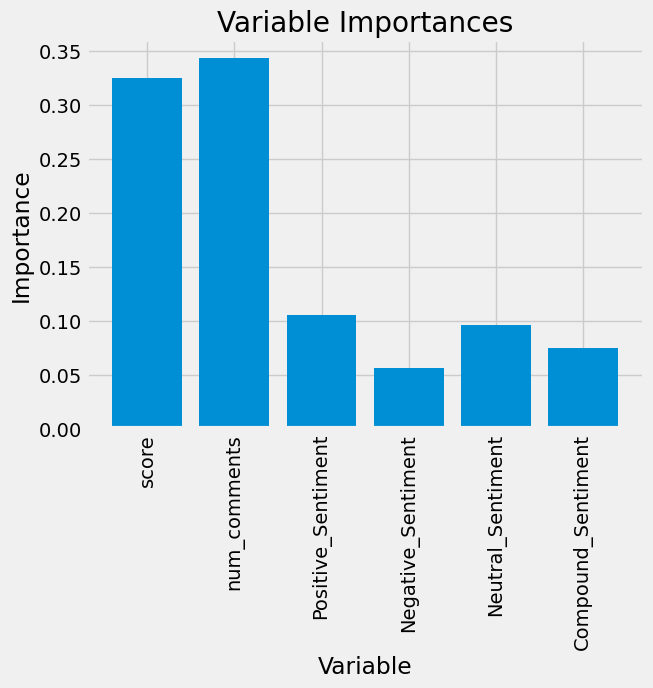

In [130]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [131]:
# Use datetime for creating date objects for plotting
import datetime
# Dates of training values
months = dataPlug.features[:, feature_list.index('timestamp').month]
days = dataPlug.features[:, feature_list.index('timestamp').day]
years = dataPlug.features[:, feature_list.index('timestamp').year]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
# Dates of predictions
months = test_features[:, feature_list.index('timestamp').month]
days = test_features[:, feature_list.index('timestamp').day]
years = test_features[:, feature_list.index('timestamp').year]
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60');
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

ValueError: 'timestamp' is not in list